In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append("..")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
dir = '../figs/theory2/'

In [5]:
from util import plot_grid, plot_images, normalize, expand
from skimage.transform import rescale, downscale_local_mean
from torchvision.datasets import MNIST, FashionMNIST

In [6]:
def mse(x, y):
    return ((x - y)**2).mean()
def psnr(x, y):
    max_intensity = 1 if x.max() < 2 else 255
    return 10*np.log10(max_intensity**2/mse(x,y))

In [7]:
mnist = MNIST('../data/MNIST', download=True, train=True)

In [8]:
alphabet = np.concatenate([downscale_local_mean(np.array(mnist[i][0]), (2, 2))[np.newaxis] for i in range(30)])
alphabet = alphabet/255

In [9]:
noise_std = 0.8

In [10]:
np.random.seed(1)
images = alphabet[:3]
noisy_images = images + noise_std*np.random.randn(*images.shape)

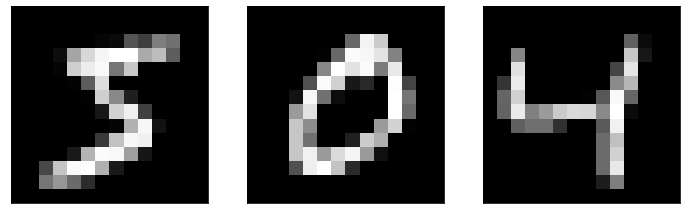

In [11]:
plot_images([np.clip(images[i],0,1) for i in range(3)])

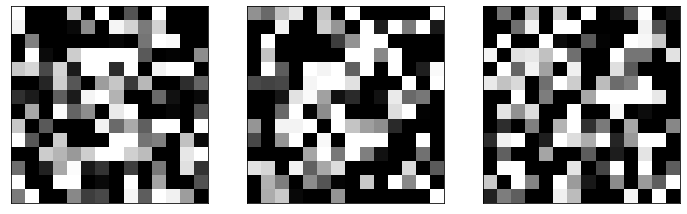

In [12]:
plot_images([np.clip(noisy_images[i],0,1) for i in range(3)])

In [13]:
K = np.cov(alphabet.reshape(len(alphabet), -1).T)
u = alphabet.reshape(len(alphabet), -1).mean(axis = 0)
L = np.eye(len(K)) * noise_std**2

In [14]:
np.random.seed(1)
N = len(K)
size = alphabet[0].shape[-1]
samples = 6
y = u + np.random.multivariate_normal(np.zeros(N), K, size=samples)
s = np.random.multivariate_normal(np.zeros(N), L, size=samples)
x = y + s
gaussian_noisy_images = x.reshape(len(x), size, size)
gaussian_images = y.reshape(len(y), size, size)

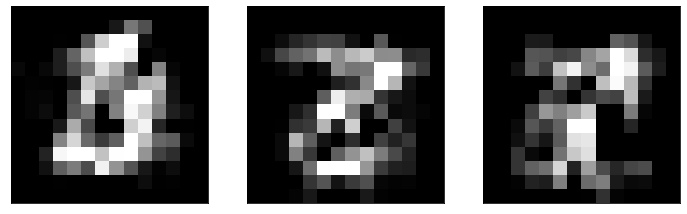

In [15]:
plot_images([np.clip(gaussian_images[i],0,1) for i in range(3)])

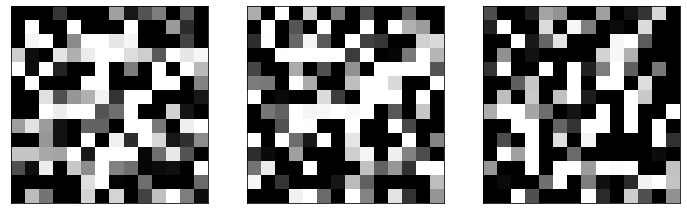

In [16]:
plot_images([np.clip(gaussian_noisy_images[i],0,1) for i in range(3)])

In [17]:
def optimal_predictor(x, alphabet, std):
    squared_distances = ((x - alphabet)**2).sum(axis = (-1,-2))
    squared_distances = squared_distances - squared_distances.min()
    weights = np.exp(-squared_distances/(2 * std * std))
    weights = weights/weights.sum()
    return np.sum(weights[:, np.newaxis, np.newaxis] * alphabet, axis = 0)

In [18]:
def optimal_predictor_mask(x, alphabet, std, n_masks = 100):
    q = np.random.rand(*x.shape)

    result = np.zeros(x.shape)

    for i in range(n_masks):
        mask = (q > i/n_masks) & (q < (i+1)/n_masks)
        inv_mask = 1 - mask
        squared_distances = ((x*inv_mask - alphabet*inv_mask)**2).sum(axis = (-1,-2))
        squared_distances = squared_distances - squared_distances.min()
        weights = np.exp(-squared_distances/(2 * std * std))
        weights = weights/weights.sum()
        inferred_image = np.sum(weights[:, np.newaxis, np.newaxis] * alphabet, axis = 0)
        result += inferred_image * mask
    return result

In [19]:
def gaussian_posterior_variance(K, L, full = False):
    center = len(K)//2
    if full:
        return np.trace(K - K.dot(np.linalg.solve(K + L, K)))/len(K)
    else:
        return (K[center, center] - K[center].dot(np.linalg.solve(K + L, K[:,center])))

def gaussian_posterior_variance_masked(K, L=0, full = False):
    K_y = K + L
    
    total_var = 0

    for i in range(len(K)):
        obs = (np.arange(len(K)) != i)
        K_y_obs = K_y[obs,:][:, obs]
        Sigma_obs_i = K[i, i] - np.dot(K[i,obs], np.linalg.solve(K_y_obs, K[obs,i]))
        
        if not full:
            total_var = len(K)*Sigma_obs_i
            break
        else:
            total_var += Sigma_obs_i
    return total_var/len(K)

In [20]:
def gaussian_predictor(x, K, L):
    x_long = x.reshape(-1)
    y_hat = K.dot(np.linalg.solve(K + L, x_long))
    
    return y_hat.reshape(x.shape)
def gaussian_predictor_masked(x, K, L):
    K_y = K + L
    x_long = x.reshape(-1)
    y_hat = np.zeros(x_long.shape)
    for i in range(len(K)):
        obs = (np.arange(len(K)) != i)
        K_y_obs = K_y[obs,:][:, obs]
        y_hat[i] = K[i:i+1,obs].dot(np.linalg.solve(K_y_obs, x_long[obs]))[0]
    return y_hat.reshape(x.shape)

In [21]:
denoised_images = [optimal_predictor_mask(x, alphabet, noise_std) for x in noisy_images]
gaussian_denoised_images = [gaussian_predictor_masked(x, K, L) for x in gaussian_noisy_images]

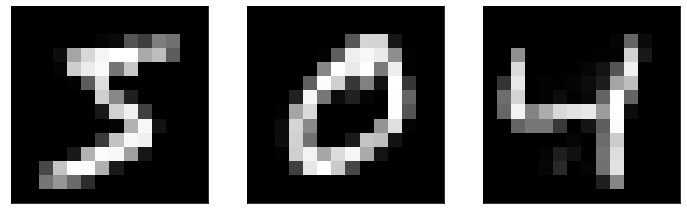

In [22]:
plot_images([np.clip(denoised_images[i],0,1) for i in range(3)])

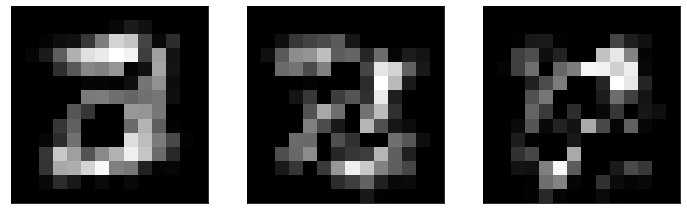

In [23]:
plot_images([np.clip(gaussian_denoised_images[i],0,1) for i in range(3)])

In [24]:
# plt.imsave(dir + 'alphabet_clean.png', 
#                expand(np.clip(images[0], 0, 1), 5), cmap = 'Greys_r')
# plt.imsave(dir + 'alphabet_noisy.png', 
#                expand(np.clip(noisy_images[0], 0, 1), 5), cmap = 'Greys_r')
# plt.imsave(dir + 'alphabet_denoised.png', 
#                expand(np.clip(denoised_images[0], 0, 1), 5), cmap = 'Greys_r')
# plt.imsave(dir + 'gaussian_clean.png', 
#                expand(np.clip(gaussian_images[0], 0, 1), 5), cmap = 'Greys_r')
# plt.imsave(dir + 'gaussian_noisy.png', 
#                expand(np.clip(gaussian_noisy_images[0], 0, 1), 5), cmap = 'Greys_r')
# plt.imsave(dir + 'gaussian_denoised.png', 
#                expand(np.clip(gaussian_denoised_images[0], 0, 1), 5), cmap = 'Greys_r')

In [25]:
sigma_range = np.arange(0.1, 1.5, 0.1)
n_samples = 5000

np.random.seed(3)
reconstruction_mses = [
    [mse(alphabet[i % len(alphabet)], 
         optimal_predictor(alphabet[i % len(alphabet)] + sigma*np.random.standard_normal(alphabet[0].shape), alphabet, sigma))
     for i in range(n_samples)]
    for sigma in sigma_range]

In [26]:
n_samples = 500
np.random.seed(3)
reconstruction_masked_mses = [
    [mse(alphabet[i % len(alphabet)], 
         optimal_predictor_mask(alphabet[i % len(alphabet)] + sigma*np.random.standard_normal(alphabet[0].shape), alphabet, sigma))
     for i in range(n_samples)]
    for sigma in sigma_range]

In [27]:
mses_gaussian = [gaussian_posterior_variance(K, sigma**2 * np.eye(len(K)), full = True) for sigma in sigma_range]
mses_gaussian_masked = [gaussian_posterior_variance_masked(K, sigma**2 * np.eye(len(K)), full = True) for sigma in sigma_range]

In [28]:
mses_masked = np.array([np.mean(t) for t in reconstruction_masked_mses])
median_mses_masked = np.array([np.median(t) for t in reconstruction_masked_mses])
stds_masked = np.array([np.std(t) for t in reconstruction_masked_mses])
mean_stds_masked = stds_masked/np.sqrt(len(reconstruction_masked_mses[0]))

mses = np.array([np.mean(t) for t in reconstruction_mses])
median_mses = np.array([np.median(t) for t in reconstruction_mses])
stds = np.array([np.std(t) for t in reconstruction_mses])
mean_stds = stds/np.sqrt(len(reconstruction_mses[0]))

Text(0, 0.5, 'MSE')

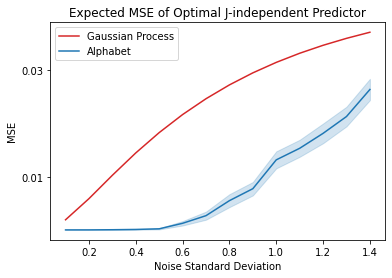

In [29]:
plt.plot(sigma_range, mses_gaussian_masked, label = 'Gaussian Process', color = 'C3')

plt.plot(sigma_range, mses_masked, label = 'Alphabet')
plt.fill_between(sigma_range, mses_masked - 2*mean_stds_masked, mses_masked + 2*mean_stds_masked,
                 color='C0', alpha=0.2)

plt.yticks([0.01, 0.03])

plt.legend()
plt.xlabel("Noise Standard Deviation")
plt.title("Expected MSE of Optimal J-independent Predictor")
plt.ylabel("MSE")

# plt.savefig(dir + 'alphabet.pdf')

# Export bare versions for Illustrator

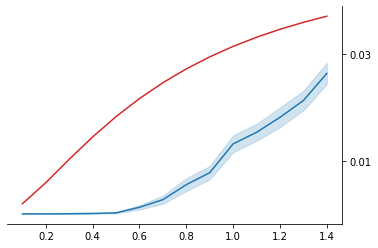

In [30]:
plt.plot(sigma_range, mses_gaussian_masked, label = 'Gaussian Process', color = 'C3')

plt.plot(sigma_range, mses_masked, label = 'Alphabet')
plt.fill_between(sigma_range, mses_masked - 2*mean_stds_masked, mses_masked + 2*mean_stds_masked,
                 color='C0', alpha=0.2)

plt.yticks([0.01, 0.03])
plt.gca().yaxis.tick_right()

# Hide the right and top spines
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# plt.savefig(dir + 'alphabet_bare.pdf')